In [1]:
# импортируем библиотеки

import pandas as pd
import pandahouse
import numpy as np
import hashlib
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from swifter import swifter

In [2]:
# считываем нужные данные из clickhouse в датафрейм

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230820'
}

q = '''
SELECT
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM 
    {db}.feed_actions 
WHERE 
    toDate(time) BETWEEN '2023-07-23' AND '2023-07-29'
    AND exp_group IN (2, 3)
GROUP BY exp_group, user_id
'''

df = pandahouse.read_clickhouse(q, connection=connection)

print(df.head())

   exp_group  user_id  likes  views       ctr
0          3   115383     38    248  0.153226
1          3    10326     24    132  0.181818
2          3   123580     25    122  0.204918
3          2   131473     19     98  0.193878
4          2    23985     12     44  0.272727


In [58]:
# Симулируем проведение 10000 А/А-тестов на подвыборках без повторения в 500 юзеров из 2 и 3 экспериментальной группы

p_values = [stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500),
                           df[df.exp_group == 3].ctr.sample(500),
                           equal_var=False).pvalue 
           for _ in range(10000)]

<Axes: ylabel='Count'>

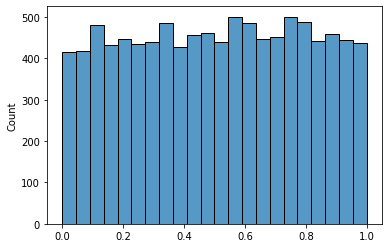

In [59]:
# Строим гистограмму распределения получившихся 10000 p-values

sns.histplot(p_values)

In [65]:
# Считаем, какой процент p values оказался меньше либо равен 0.05

len([p for p in p_values if p <= 0.05]) / len(p_values) * 100


4.47

### Вывод

4.47% p-values меньше или равны 0.05, это говорит о том, что случайные статистические различия между группами возникают в пределах ожидаемого уровня значимости. Что подтверждает корректность работы системы сплитования.
